In [1]:
# Design of a 100 ns control pulse, parameterized as a Fourier series, to 
# implement a π/2 gate that is robust to amplitude miscalibration and 
# frequency detuning.

# The control fields are expressed as:
#     Ω_x(t) = 2π·ν_Ref · Σ a_n · sin((2n-1)·π·t/T)
#     Ω_y(t) = 2π·ν_Ref · Σ b_n · sin(2n·π·t/T)
# where a_n and b_n are the Fourier coefficients to be optimized, 
# ν_Ref is a reference pulse amplitude, and T is the total pulse duration.

# Robustness is ensured by defining a grid of Hamiltonian parameters 
# (detuning and amplitude scaling factors) and optimizing a_n and b_n 
# to maximize the average gate fidelity across this grid.

# Estimated script runtime: ~ 15 minutes.

# AUTHOR:
#     Leo Van Damme / Technical University of Munich, 2025

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from Module.parameters import ProblemParameters
from Module.grape import *
from Module.pulse_utils import *
from Module.phys_utils import *

In [3]:
# Hamiltonian parameter grid map
Na = 5  # Number of sampling points in the amplitude range
Nd = 5  # Number of sampling points in the detuning range
AmpError = np.linspace(-0.1,0.1,Na)               # Amplitude error [-10%, 10%]
Detuning = 0.2e6*np.linspace(-1,1,Nd)             # Detuning [-0.2MHz, 0.2MHz]
DetMap, AmpMap = np.meshgrid(Detuning, AmpError)  # Make grid of inhomogeneities
AmpVec = np.reshape(AmpMap,(Na*Nd,))              # Reshape as vector (Na*Nb,)
DetVec = np.reshape(DetMap,(Na*Nd,))              # Reshape as vector (Na*Nb,)

In [4]:
# Problem parameters
p = ProblemParameters(
                alpha=-200e6,          # Anharmonicity parameter in Hz
                QubitFreq=5e9+DetVec,  # Qubit freq (+ detuning) in Hz
                CarrFreq = 5e9,        # Carrier frequency in Hz
                nuRef=5e6,             # Reference pulse amplitude in Hz
                AmpScale=1+AmpVec,     # Amplitude scale factor
                NLevels = 3,           # Number of energy levels
                Nt=200,                # Number of time steps
                dt=0.5e-9,             # Time step in s.
                CompSpace=[0,1],       # Computational states |0>, |1>
                Target =[[1,-1j],      # Target gate on comp. space
                         [-1j,1]]/np.sqrt(2) 
                )

In [5]:
# Define analytical basis for the pulse
Ncoeffs = 5
fx = np.zeros((Ncoeffs,p.Nt))
fy = np.zeros((Ncoeffs,p.Nt))
tau=np.linspace(0,1,p.Nt)
for n in range(Ncoeffs):
    fx[n,:] = np.sin((2*n+1)*np.pi*tau) # Harmonics of ux
    fy[n,:] = np.sin(2*(n+1)*np.pi*tau)     # Harmonics of uy

p.Set(uxBasis = fx, uyBasis = fy)  # Add to the list of parameters

In [6]:
# Initial guess of Fourier coefficients (drag-like)
a0, b0 = InitPulse(p,PulseType="CosDrag",ThetaTar=np.pi/2)

Initializing pulse...
Compiling cost function... Done.
Pulse initialized.


In [7]:
# Choose optimization parameters
gopt=Grape(
        Maxiter=2000,          # Maximum number of iterations
        MaxInPhase = 15e6,     # Maximum In-phase amplitude allowed
        MaxQuadrature = 15e6   # Maximum quadrature amplitude allowed
        )

In [8]:
# Optimize Fourier coefficients
a, b, J = gopt.Optimize(p, a0, b0)

Compiling cost function... Done.
########### OPTIMIZATION RESULTS ###########
Cost before optimization: 0.004504072328
Cost after optimization: 0.000532359551
Number of Iterations: 2000
Message: The maximum number of iterations has been reached


In [9]:
# Compute pulse shapes as a function of time
# ux(t) = Σ a(n)*fx(n,t)
# uy(t) = Σ b(n)*fy(n,t)
ux = p.TruxBasis @ a
uy = p.TruyBasis @ b

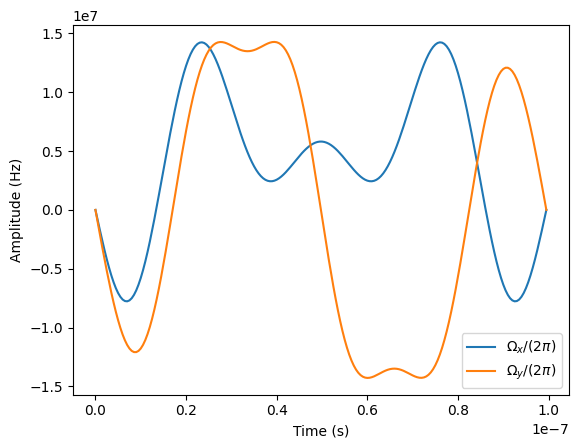

In [10]:
# Display pulse shapes in Hz
plt.figure()
plt.plot(p.tc,p.nuRef*ux,p.tc,p.nuRef*uy)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (Hz)')
plt.legend([r'$\Omega_x/(2\pi)$', r'$\Omega_y/(2\pi)$'])
plt.show()

In [11]:
# Extend the parameter map for better plots
Na = 35
Nd = 35
AmpError = np.linspace(-0.2,0.2,Na)               # Amplitude error [-20%,20%]
Detuning = 0.65e6*np.linspace(-1,1,Nd)            # Detuning [-0.65 MHz,0.65 MHz]
DetMap, AmpMap = np.meshgrid(Detuning, AmpError)  # Make grid of inhomogeneities
AmpVec = np.reshape(AmpMap,(Na*Nd,))              # Reshape as vector (Na*Nb,)
DetVec = np.reshape(DetMap,(Na*Nd,))              # Reshape as vector (Na*Nb,)

# Update parameters
p.Set(QubitFreq = 5e9 + DetVec, AmpScale = 1 + AmpVec)

In [12]:
# Compute the vectorized fidelity map
F = GateFidelityMap(p,ux,uy)

Computation of the gate fidelity map 1225/1225


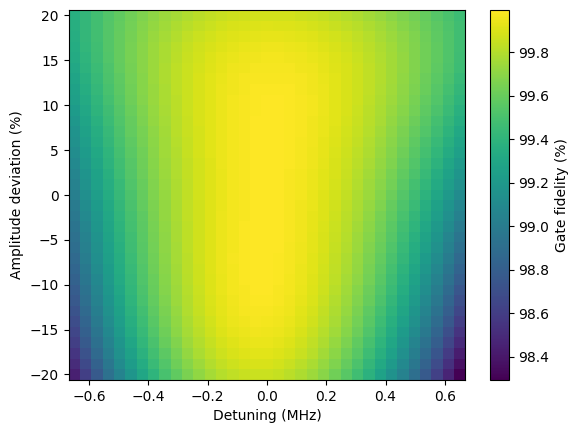

In [13]:
# Display the result
FMap = F.reshape((Nd,Na))
plt.pcolormesh(DetMap/1e6, AmpMap*100, FMap*100, shading='auto')
plt.colorbar(label='Gate fidelity (%)')
plt.xlabel('Detuning (MHz)')
plt.ylabel('Amplitude deviation (%)')
plt.show()